In [1]:
import os
import time

import numpy as np
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision as tv
import torchvision.datasets as datasets
from art.attacks.evasion import FastGradientMethod 
from art.estimators.classification import PyTorchClassifier

from util import get_roc, get_shape, get_correct_examples
from lid import get_lid

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cpu
CPU threads: 6


In [4]:
PATH = 'data'
BATCH_SIZE = 128
EPOCHS = 5

In [5]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH, train=False, download=True, transform=transforms)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Create Neural Network model

model = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(9216, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.LogSoftmax(dim=1)
)
model.to(device)
print('Number of layers: {}'.format(len(list(model.children()))))

Number of layers: 10


In [7]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [8]:
def validate(model, loader, loss):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.NLLLoss()

In [10]:
since = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
    va_loss, va_acc = validate(model, dataloader_test, loss)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 42.7s Train Loss: 0.3887 Accuracy: 88.6183%, Test Loss: 0.1384 Accuracy: 95.5700%
[ 2] 0m 42.3s Train Loss: 0.1204 Accuracy: 96.3350%, Test Loss: 0.0883 Accuracy: 97.3400%
[ 3] 0m 41.3s Train Loss: 0.0776 Accuracy: 97.5800%, Test Loss: 0.0661 Accuracy: 97.9000%
[ 4] 0m 43.6s Train Loss: 0.0540 Accuracy: 98.3167%, Test Loss: 0.0528 Accuracy: 98.1100%
[ 5] 0m 41.0s Train Loss: 0.0394 Accuracy: 98.7717%, Test Loss: 0.0468 Accuracy: 98.3800%
Total run time: 3m 30.8s


In [11]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.2f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.2f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 60000
Accuracy on 59343 filtered training examples: 100.00%
Test set: 10000
Accuracy on 9838 filtered test examples: 100.00%


In [28]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)
attack = FastGradientMethod(estimator=classifier, eps=0.3)

In [29]:
# Prepare dataset for adversarial examples
N_ADV = 2000
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]
pt_subset_X = tensor_test_X[indices]  # PyTorch Tensor
pt_subset_y = tensor_test_y[indices]

In [30]:
# Create adversarial examples
subset_pred = np.argmax(classifier.predict(pt_subset_X.numpy()), axis=1)
accuracy = np.sum(subset_pred == pt_subset_y.numpy()) / float(len(subset_pred))
print("Model accuracy on clean examples: {}%".format(accuracy * 100))

# Generate adversarial examples
subset_adv = attack.generate(x=pt_subset_X.numpy())
subset_pred = np.argmax(classifier.predict(subset_adv), axis=1)

accuracy = np.sum(subset_pred == pt_subset_y.numpy()) / float(len(subset_pred))
print("Model accuracy on adversarial examples: {}%".format(accuracy * 100))

Model accuracy on clean examples: 100.0%
Model accuracy on adversarial examples: 4.95%


In [31]:
# Create noisy data
subset_X = pt_subset_X.numpy()
# Average L2 distance
l2_adv = np.mean([np.linalg.norm(dif) for dif in (subset_X[-1000:] - subset_adv[-1000:])])
print('L2 distance between adversairal examples and clean data: {}'.format(l2_adv))
std = l2_adv / 20

noise = np.random.normal(0, scale=std, size=subset_X[-1000:].shape)
subset_noisy = np.minimum(np.maximum(subset_X[-1000:] + noise, 0.0), 1.0)

# L2 distance between noisy data and clean data
l2_noise = np.mean([np.linalg.norm(dif) for dif in (subset_X[-1000:] - subset_noisy)])
print('L2 distance between noisy data and clean data: {}'.format(l2_noise))

L2 distance between adversairal examples and clean data: 6.178483009338379
L2 distance between noisy data and clean data: 6.21697941745114


In [53]:
# Compute LID characteristics
characteristics, labels = get_lid(model, subset_X[-1000:], subset_noisy, subset_adv[-1000:], 
                                 k=20, batch_size=100)
# characteristics, labels = get_lid(model, subset_X[-1000:], subset_X[:1000], subset_adv[-1000:], 
#                                  k=20, batch_size=100)

100%|██████████| 10/10 [00:34<00:00,  3.40s/it](1000, 9) (2000, 9)



In [54]:
scaler = MinMaxScaler().fit(characteristics)
characteristics = scaler.transform(characteristics)

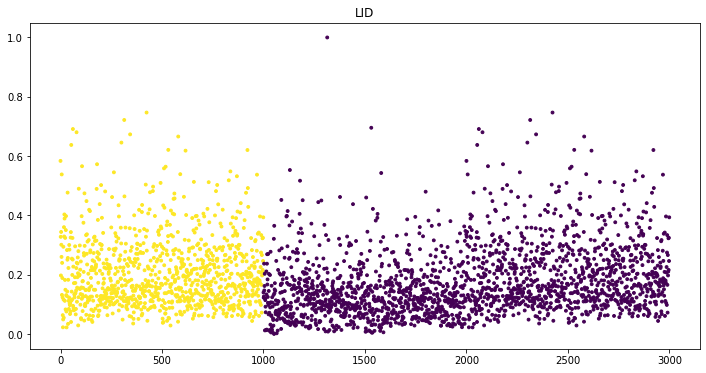

In [55]:
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(characteristics)), characteristics[:,-1], c=labels, s=8)
plt.title('LID')
plt.show()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(characteristics, labels, test_size=0.2, shuffle=True)
print("Train data size: ", X_train.shape)
print("Test data size: ", X_test.shape)

Train data size:  (2400, 9)
Test data size:  (600, 9)


In [57]:
from sklearn.linear_model import LogisticRegressionCV

In [58]:
reg_model = LogisticRegressionCV(n_jobs=-1).fit(X_train, y_train)

y_pred = reg_model.predict_proba(X_test)[:, 1]
y_label_pred = reg_model.predict(X_test)

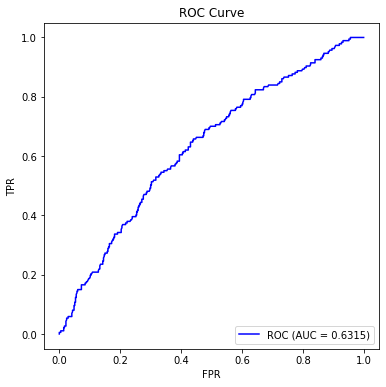

Detector ROC-AUC score: 0.6315, accuracy: 0.6883, precision: 0.0000, recall: 0.0000


In [63]:
_, _, auc_score, _ = get_roc(y_test, y_pred, show_plot=True)
precision = precision_score(y_test, y_label_pred)
recall = recall_score(y_test, y_label_pred)
acc = accuracy_score(y_test, y_label_pred)

print('Detector ROC-AUC score: {:0.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(
    auc_score, acc, precision, recall))